<a href="https://colab.research.google.com/github/ShubhamGupta2505/Deep_Learning_Practice/blob/main/nlp_subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

## Get the original dataset

We'll once again use the dataset containing Amazon and Yelp reviews. This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2023-05-19 09:07:13--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.130.101, 74.125.130.113, 74.125.130.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.130.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/68irhhbi3eoes0nesb4m48huvc290m3l/1684487175000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=0b7cc806-d6f8-4697-b729-8087b4e96a4e [following]
--2023-05-19 09:07:13--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/68irhhbi3eoes0nesb4m48huvc290m3l/1684487175000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=0b7cc806-d6f8-4697-b729-8087b4e96a4e
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to doc-08-

In [3]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

## Create a subwords dataset

We can use the existing Amazon and Yelp reviews dataset with `tensorflow_datasets`'s `SubwordTextEncoder` functionality. `SubwordTextEncoder.build_from_corpus()` will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

The Amazon and Yelp dataset we are using isn't super large, so we'll create a subword `vocab_size` of only the 1,000 most common words, as well as cutting off each subword to be at most 5 characters.

Check out the related documentation [here](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#build_from_corpus).

In [4]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [5]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Replace sentence data with encoded subwords

Now, we'll re-create the dataset to be used for training by actually encoding each of the individual sentences. This is equivalent to `text_to_sequences` with the `Tokenizer` we used in earlier exercises.

In [6]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [7]:
# Check the sentences are appropriately replaced
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


## Final pre-processing

Before training, we still need to pad the sequences, as well as split into training and test sets.

In [8]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Train a Sentiment Model

In [9]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 18s 203ms/step - loss: 0.6922 - accuracy: 0.5210 - val_loss: 0.6956 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 4s 85ms/step - loss: 0.6901 - accuracy: 0.5273 - val_loss: 0.6963 - val_accuracy: 0.4236
Epoch 3/30
50/50 [==============================] - 3s 55ms/step - loss: 0.6863 - accuracy: 0.5468 - val_loss: 0.6942 - val_accuracy: 0.4612
Epoch 4/30
50/50 [==============================] - 2s 40ms/step - loss: 0.6787 - accuracy: 0.6001 - val_loss: 0.6866 - val_accuracy: 0.5188
Epoch 5/30
50/50 [==============================] - 1s 19ms/step - loss: 0.6652 - accuracy: 0.6598 - val_loss: 0.6752 - val_accuracy: 0.5714
Epoch 6/30
50/50 [==============================] - 4s 78ms/step - loss: 0.6438 - accuracy: 0.7213 - val_loss: 0.6558 - val_accuracy: 0.6441
Epoch 7/30
50/50 [==============================] - 1s 23ms/step - loss: 0.6145 - accuracy: 0.7602 - val_loss: 0.6219 - val_accuracy: 0.7569
Epoch 8/30


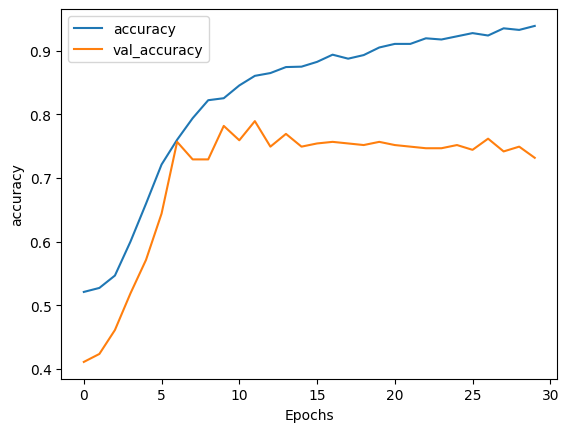

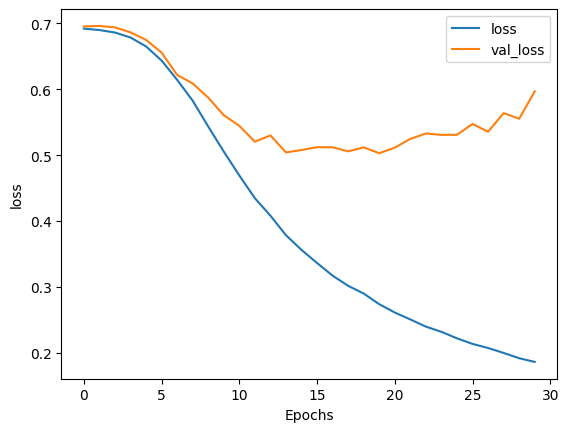

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [13]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [14]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>